In [1]:
import fairseq
import torch 
import torch.nn as nn
from fairseq.models import (
    FairseqEncoder, 
    register_model, 
    register_model_architecture
)
from fairseq.models.wav2vec.wav2vec2 import Wav2Vec2Model, Wav2Vec2Config
from fairseq.models import BaseFairseqModel, register_model
from fairseq.models.wav2vec import (
    TransformerEncoder,
    TransformerSentenceEncoderLayer,
    Wav2Vec2Model,
    Wav2VecEncoder    
)
from fairseq.data.audio.speech_to_text_dataset import _collate_frames


[2024-01-23 06:39:58,288] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# original_forward = TransformerSentenceEncoderLayer.forward

# def generate_2d_causal_mask(seq_len, device='cpu'):
#     """
#     Generates a 2D causal mask for multi-head attention.
    
#     Args:
#         seq_len (int): The length of the sequence.
#         device (str): The device on which to create the mask.
    
#     Returns:
#         torch.Tensor: A 2D causal attention mask.
#     """
#     mask = torch.triu(torch.ones((seq_len, seq_len), device=device), diagonal=1)
#     mask = mask.masked_fill(mask == 1, float('-inf'))
#     return mask

# def causal_forward(
#     self,
#     x: torch.Tensor,
#     self_attn_mask: torch.Tensor = None,
#     self_attn_padding_mask: torch.Tensor = None,
#     need_weights: bool = False,
#     att_args=None,
# ):
#     # Generate the causal mask
#     # print(x)
#     # print(x.size(2))
#     # print(self_attn_mask)
#     causal_mask = generate_2d_causal_mask(x.size(0), device=x.device)
    
#     if self_attn_mask is not None:
#         self_attn_mask = self_attn_mask + causal_mask
#     else:
#         self_attn_mask = causal_mask

#     return original_forward(
#         self, x, 
#         self_attn_mask=self_attn_mask, 
#         self_attn_padding_mask=self_attn_padding_mask, 
#         need_weights=need_weights,
#         att_args=att_args)


In [3]:
def generate_2d_causal_mask(seq_len, dtype, device='cpu'):
    """
    Generates a 2D causal mask for multi-head attention.
    
    Args:
        seq_len (int): The length of the sequence.
        device (str): The device on which to create the mask.
    
    Returns:
        torch.Tensor: A 2D causal attention mask.
    """
    # mask = torch.triu(torch.ones((seq_len, seq_len), device=device), diagonal=1)
    mask = torch.triu(torch.ones((seq_len, seq_len), device=device, dtype=dtype), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

def causal_forward(
    self,
    x: torch.Tensor,
    self_attn_mask: torch.Tensor = None,
    self_attn_padding_mask: torch.Tensor = None,
    need_weights: bool = False,
    att_args=None,
):
    """
    LayerNorm is applied either before or after the self-attention/ffn
    modules similar to the original Transformer imlementation.
    """
    # causal_mask = generate_2d_causal_mask(x.size(0), device=x.device)
    causal_mask = generate_2d_causal_mask(x.size(0), dtype=x.dtype,device=x.device)
    
    if self_attn_mask is not None:
        self_attn_mask = self_attn_mask + causal_mask
    else:
        self_attn_mask = causal_mask
        
    residual = x

    if self.layer_norm_first:
        x = self.self_attn_layer_norm(x)
        x, attn = self.self_attn(
            query=x,
            key=x,
            value=x,
            key_padding_mask=self_attn_padding_mask,
            attn_mask=self_attn_mask,
            need_weights=True,
        )
        x = self.dropout1(x)
        x = residual + x

        residual = x
        x = self.final_layer_norm(x)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        layer_result = x

        x = self.dropout3(x)
        x = residual + x
    else:
        x, attn = self.self_attn(
            query=x,
            key=x,
            value=x,
            key_padding_mask=self_attn_padding_mask,
            need_weights=True,
        )

        x = self.dropout1(x)
        x = residual + x

        x = self.self_attn_layer_norm(x)

        residual = x
        x = self.activation_fn(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        layer_result = x

        x = self.dropout3(x)
        x = residual + x
        x = self.final_layer_norm(x)

    return x, (attn, layer_result)

In [4]:
# try replace multihead attention with causal multihead attention


In [5]:
# try replace wav2vec forward

In [6]:
def replace_forward():
    TransformerSentenceEncoderLayer.forward = causal_forward

In [7]:
speech_tower_path = '/mnt/taurus/data/xixu/models/wav2_vec_vox_960h_pl.pt'
state = fairseq.checkpoint_utils.load_checkpoint_to_cpu(speech_tower_path)
model = Wav2VecEncoder(state['cfg']['model'], None)
new = {}
for key in state['model'].keys():
    new_key = key.replace('w2v_encoder.', '')
    if not new_key.startswith('proj'):
        new[new_key] = state['model'][key]
model.load_state_dict(new, strict=True)
model = model.w2v_model
replace_forward()

/mnt/taurus/home/siqiouyang/anaconda3/envs/sllama/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


torch.Size([1, 466, 1024])


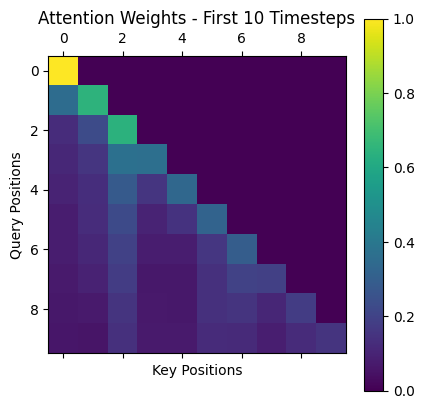

In [8]:
#Attention Weight
import matplotlib.pyplot as plt
import torchaudio
import numpy
from train.dataset import PromptSpeechToTextDatasetCreator, SpeechToTextDatasetItem


replace_forward()
def visualize_attention_weights(model, plot_size=10):
    test_dataset = PromptSpeechToTextDatasetCreator.from_tsv("/mnt/data/xixu/datasets/must-c-v1.0/en-es/", 'tst-COMMON_1' )
    for test_data in test_dataset:
        source, ref, id = test_data.source, test_data.target, test_data.id                  
        speech_batch = _collate_frames([source], is_audio_input=True)

        model.eval()
        # Forward pass through the model
        with torch.no_grad():
            result = model.extract_features(speech_batch, padding_mask=None)
        # ((x, z, lr))
        # changed https://github.com/facebookresearch/fairseq/blob/fad2c4d1ebe14d974876de52dcb06db6d99b0b4a/fairseq/models/wav2vec/wav2vec2.py#L1330C34-L1330C34 
        # to get attention weights  
        attn = result['layer_results'][0][1]
        feature = result["x"]
        print(feature.size())
        # print(attn.size())
        attn = attn[0] if attn.ndim == 3 else attn
        # print(attn.size())
        # Select a smaller portion of the attention matrix to visualize
        small_attn = attn[:plot_size, :plot_size].cpu().numpy()

        # Visualize the attention weights
        plt.matshow(small_attn)
        plt.title(f"Attention Weights - First {plot_size} Timesteps")
        plt.xlabel("Key Positions")
        plt.ylabel("Query Positions")
        plt.colorbar()
        plt.show()

# Call the function with the model and desired input length
visualize_attention_weights(model, plot_size=10)


# Inference

## Incremental w2v2 encoding

In [38]:
from fairseq.modules import MultiheadAttention

In [39]:
mha = MultiheadAttention(512, 8, dropout=0.0, self_attention=True)

In [40]:
incremental_state = {}

In [41]:
x = torch.rand(2, 1, 512)

In [42]:
attn_mask = generate_2d_causal_mask(x.size(0), dtype=x.dtype, device=x.device)

In [43]:
attn, attn_weights = mha.forward(x, x, x, incremental_state=incremental_state, attn_mask=attn_mask)

{}
torch.Size([8, 2, 2]) torch.Size([1, 2, 2])


In [51]:
y = torch.rand(3, 1, 512)

In [48]:
attn_mask = generate_2d_causal_mask(5, dtype=x.dtype, device=x.device)[2:]

In [52]:
attn, attn_weights = mha.forward(y, y, y, incremental_state=incremental_state, attn_mask=attn_mask)

{'prev_key': tensor([[[[-3.4721e-01,  6.8438e-02,  2.2853e-01,  ..., -9.4461e-02,
           -2.8663e-01, -2.4116e-01],
          [-3.7732e-01,  9.6393e-02,  2.8277e-01,  ...,  4.0914e-01,
            1.9507e-01, -2.6538e-01]],

         [[ 6.2529e-01, -4.8792e-02,  4.1974e-01,  ..., -2.0654e-02,
            6.9791e-04, -1.5041e-02],
          [ 1.7753e-01, -5.4947e-01,  9.4435e-01,  ...,  6.4753e-01,
            1.6760e-01, -3.7800e-02]],

         [[ 1.4639e-01, -1.9122e-02,  5.2609e-01,  ..., -4.8424e-01,
            1.6980e-01,  2.9214e-01],
          [ 1.7522e-01, -4.4485e-01,  7.2312e-01,  ..., -4.6651e-01,
           -6.8658e-02,  3.8094e-01]],

         ...,

         [[-2.4122e-01, -5.7706e-02,  4.5700e-02,  ...,  1.0203e-01,
           -6.2049e-01,  3.3837e-01],
          [-1.7787e-01,  1.5897e-01,  1.5635e-02,  ...,  1.3330e-01,
            6.1628e-02,  5.4253e-01]],

         [[ 1.7910e-01,  2.5651e-01,  1.2945e-01,  ...,  3.1836e-01,
           -1.8421e-01, -2.0488e-01],
 

In [71]:
list(incremental_state.values())[0]['prev_key'].size()

torch.Size([1, 8, 5, 64])

## Incremental llama encoding with w2v2 input

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import argparse, sys, time, json
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import torch, transformers
from eval.utils import disable_torch_init
from model.model import SpeechLlamaForCausalLM, SpeechLlamaModel, SpeechLlamaConfig
from model.utils import KeywordsStoppingCriteria
from fairseq.data.audio.speech_to_text_dataset import _collate_frames
from train.dataset import PromptSpeechToTextDatasetCreator, SpeechToTextDatasetItem
import conversation as conversation_lib
from conversation import SeparatorStyle
from train.uni_wav2vec_monkey_patch import replace_forward

import requests

import torch.nn.functional as F

args = argparse.Namespace()
args.model_name = '/mnt/taurus/data/xixu/runs/sllama/en-es/7b/uni/stage2/checkpoint-2000'
args.length_adapter_path = os.path.join(args.model_name, 'length_adapter.bin')
args.mlp_adapter_path = os.path.join(args.model_name, 'mlp_adapter.bin')
args.speech_tower_path = os.path.join(args.model_name, 'speech_tower.bin')

load_type = torch.float16
disable_torch_init()
model_name = os.path.expanduser(args.model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    args.model_name,
    padding_side="right",
    use_fast=False,
)
config = json.load(open(os.path.join(args.model_name, 'config.json')))
config['large_model'] = True
update_config = os.path.join(args.model_name, 'config_large.json')
json.dump(config, open(update_config, 'w'), indent=2)
# replace_llama_attn_with_flash_attn()
model = SpeechLlamaForCausalLM.from_pretrained(args.model_name,
                                                torch_dtype=load_type,
                                                low_cpu_mem_usage=True,
                                                device_map='auto',
                                                config=update_config,).eval()
if 'model.embed_tokens' in model.hf_device_map.keys():
    device_input = 'cuda:' + str(model.hf_device_map['model.embed_tokens'])    
    device_output = 'cuda:' + str(model.hf_device_map['lm_head'])    
else:
    device_input = 'cuda'  
    device_input = 'cuda'
length_after_ssl, length_after_adp = model.model.initialize_speech_modules(
    speech_tower_path='/mnt/taurus/data/xixu/models/wav2_vec_vox_960h_pl.pt',
    speech_tower_type=None,
    len_adapter_channels=model.config.len_adapter_channels,
    len_adapter_kernel_sizes=model.config.len_adapter_kernel_sizes,
    ssl_fintuned=model.config.ssl_fintuned,
)
model.model.speech_tower.to(dtype=load_type, device=device_input)

length_adapter_weights = torch.load(args.length_adapter_path, map_location='cpu')
mlp_adapter_weights = torch.load(args.mlp_adapter_path, map_location='cpu')
speech_tower_weights = torch.load(args.speech_tower_path, map_location='cpu')


model.model.mm_length_adapter.load_state_dict(length_adapter_weights)
model.model.mm_mlp_adapter.load_state_dict(mlp_adapter_weights)
model.model.speech_tower.load_state_dict(speech_tower_weights)

model.model.mm_length_adapter.to(dtype=load_type, device=device_input)
model.model.mm_mlp_adapter.to(dtype=load_type, device=device_input)
model.model.speech_tower.to(dtype=load_type, device=device_input)

[2024-01-23 19:26:11,734] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
2024-01-23 19:26:16 | INFO | accelerate.utils.modeling | We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at /mnt/taurus/data/xixu/runs/sllama/en-es/7b/uni/stage2/checkpoint-2000 were not used when initializing SpeechLlamaForCausalLM: ['model.speech_tower.encoder.layers.18.final_layer_norm.weight', 'model.speech_tower.encoder.layers.1.final_layer_norm.weight', 'model.speech_tower.encoder.layers.22.fc2.weight', 'model.speech_tower.encoder.layers.21.fc2.weight', 'model.mm_mlp_adapter.weight', 'model.speech_tower.encoder.layers.17.final_layer_norm.weight', 'model.speech_tower.encoder.layers.19.fc2.weight', 'model.speech_tower.encoder.layers.22.self_attn.k_proj.weight', 'model.speech_tower.encoder.layers.11.fc1.bias', 'model.speech_tower.encoder.layers.0.self_attn.v_proj.weight', 'model.speech_tower.encoder.layers.17.self_attn.out_proj.bias', 'model.speech_tower.encoder.layers.2.self_attn.k_proj.weight', 'model.speech_tower.encoder.layers.6.self_attn.v_proj.weight', 'model.speech_tower.encoder.layers.12.self_attn_layer_norm.weight', 'model.speech_tower.enco

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU(approximate='none')
      )
      (1-4): 4 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU(approximate='none')
      )
      (5-6): 2 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32Laye

In [2]:
llama_forward = super(SpeechLlamaModel, model.model).forward
input_ids = torch.LongTensor([[0, 1, 2, 3, 4]]).to('cuda')
llama_output = llama_forward(
    input_ids=input_ids,
    use_cache=True
)
llama_output_3 = [
    [llama_output.past_key_values[i][j][:, :, :3, :] for j in range(2)]
    for i in range(32) 
]

In [3]:
llama_output_incremental = llama_forward(
    input_ids=input_ids[:, 3:],
    past_key_values=llama_output_3,
    use_cache=True,
)

In [24]:
llama_output_3[0][0].size()

torch.Size([1, 32, 3, 128])

In [25]:
llama_output_incremental.past_key_values[0][0].size()

torch.Size([1, 32, 5, 128])